In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.integrate import cumtrapz

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

# train data
train_features = pd.read_csv('../data/dengue_features_train.csv')
labels = pd.read_csv('../data/dengue_labels_train.csv')
train_features['total_cases'] = labels['total_cases']
print(train_features.shape)

# test data
test_features = pd.read_csv('../data/dengue_features_test.csv')
print(test_features.shape)

# separate features for the two cities
sj = train_features[train_features.city=='sj'].copy()
sjtest = test_features[test_features.city=='sj'].copy()
iq = train_features[train_features.city=='iq'].copy()
iqtest = test_features[test_features.city=='iq'].copy()

train_features.shape

(1456, 25)
(416, 24)


(1456, 25)

In [23]:
# processes san juan dataset
def process_sj(features, train=True):
    # fix weeks
    if train:
        features.loc[:,'weekofyear_fixed'] = np.where(features.year==1993,
                                                    features.weekofyear+1, features.weekofyear)
        for year in [1994,1995,1999,2000,2005,2006]:
            features.loc[:,'weekofyear_fixed'] = np.where(features.year==year,
                                                    features.weekofyear_fixed+1, features.weekofyear_fixed)
        features.loc[:,'weekofyear'] = np.where(features.weekofyear_fixed>52,
                                                    1, features.weekofyear_fixed)
        
    else:
        features.loc[:,'weekofyear_fixed'] = np.where(features.year==2010,
                                                    features.weekofyear+1, features.weekofyear) 
        for year in [2011,2012]:
            features.loc[:,'weekofyear_fixed'] = np.where(features.year==year,
                                                    features.weekofyear_fixed+1, features.weekofyear_fixed)
        features.loc[:,'weekofyear'] = np.where(features.weekofyear_fixed>52,
                                                    1, features.weekofyear_fixed)
    
    # fill nulls with interpolation
    feats = features.interpolate(method='linear')

    # scale and average temperature readings 
    tempscols_to_average = feats.loc[:,['reanalysis_max_air_temp_k', 'station_avg_temp_c',
       'reanalysis_avg_temp_k', 'reanalysis_min_air_temp_k',
       'station_min_temp_c', 'reanalysis_dew_point_temp_k',
       'reanalysis_air_temp_k']]
    scaled_temps = pd.DataFrame(MinMaxScaler().fit_transform(tempscols_to_average), 
                            columns=tempscols_to_average.columns)
    feats.loc[:,'temps_mean'] = scaled_temps.mean(axis=1)
    #Boolean season variables
    cutoffs = [11, 30]
    feats['slowdown_season'] = np.where((feats.weekofyear<cutoffs[0]), 1, 0)

    feats['lull_season'] = np.where((feats.weekofyear>=cutoffs[0]) &
                               (feats.weekofyear<cutoffs[1]), 1, 0)
    feats['rampup_season'] = np.where((feats.weekofyear>=cutoffs[1]), 1, 0)

    # add interaction terms
    interaction_features = ['station_max_temp_c', 'temps_mean',
                           'reanalysis_relative_humidity_percent', 
                           'reanalysis_specific_humidity_g_per_kg']
    for i,feature1 in enumerate(interaction_features):
        for feature2 in interaction_features[i+1:]:
            feats[f'{feature1}_x_{feature2}'] = feats[feature1]*feats[feature2]
            
    # drop unneeded columns
    keep = ['total_cases','slowdown_season', 'lull_season', 'rampup_season',
            'station_max_temp_c','temps_mean', 'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg','reanalysis_precip_amt_kg_per_m2']
    for col in feats.columns:
        if col not in keep:
            feats = feats.drop(col, axis=1)
    # add shifted features, 3 weeks
    to_shift = ['station_max_temp_c', 'temps_mean','reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg','reanalysis_precip_amt_kg_per_m2'] 
    for i in to_shift:
        feats[i+'_1lag'] = feats[i].shift(-1)
        feats[i+'_2lag'] = feats[i].shift(-2)
        feats[i+'_3lag'] = feats[i].shift(-3)
    feats = feats.fillna(method='ffill')
    return feats

In [25]:
sj = process_sj(sj)
sj.shape

C:\Users\anees\AppData\Local\Temp\ipykernel_6080\4196076209.py:23: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  feats = features.interpolate(method='linear')
C:\Users\anees\AppData\Local\Temp\ipykernel_6080\4196076209.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feats = feats.fillna(method='ffill')


(936, 24)

In [27]:
# x,y split
sj_X = sj.drop(['total_cases'], axis=1)
sj_y = sj.total_cases

# train test split for san juan data
X_train_sj, X_test_sj, y_train_sj, y_test_sj = train_test_split(
    sj_X, sj_y, test_size=0.3)
print(X_train_sj.shape)
print(X_test_sj.shape)

(655, 23)
(281, 23)


In [29]:
# training features for iquitos
iq = train_features[train_features.city=='iq'].copy()
print(iq.shape)

def process_iq(features, train=True):
    '''Returns a dataset ready for training or prediction'''
    #Fix Week Numbers
    if train:
        features.loc[:,'weekofyear_fixed'] = np.where(features.year==2005,
                                                      features.weekofyear+1, features.weekofyear)
        features.loc[:,'weekofyear_fixed'] = np.where(features.year==2006,
                                                      features.weekofyear_fixed+1, features.weekofyear_fixed)
        features.loc[:,'weekofyear_fixed'] = np.where(features.year==2010,
                                                      features.weekofyear_fixed+1, features.weekofyear_fixed)
        features.loc[:,'weekofyear'] = np.where(features.weekofyear_fixed>52,
                                                      1, features.weekofyear_fixed)
    else:
        features.loc[:,'weekofyear_fixed'] = np.where(features.year==2011,
                                                      features.weekofyear+1, features.weekofyear)
        features.loc[:,'weekofyear_fixed'] = np.where(features.year==2012,
                                                      features.weekofyear_fixed+1, features.weekofyear_fixed)
        features.loc[:,'weekofyear'] = np.where(features.weekofyear_fixed>52,
                                                      1, features.weekofyear_fixed)

    
    # fill nulls with interpolation
    feats = features.interpolate(method='linear')

    # add interaction terms
    interaction_features = ['station_avg_temp_c', 'reanalysis_min_air_temp_k',
                            'station_min_temp_c',
                            'reanalysis_specific_humidity_g_per_kg']
    for i, feature1 in enumerate(interaction_features):
        for feature2 in interaction_features[i+1:]:
            feats[f'{feature1}_x_{feature2}'] = feats[feature1] * feats[feature2]
            
    # season features
    cutoffs = [12, 24, 36]
    feats['fall'] = np.where((feats.weekofyear<cutoffs[0]), 1, 0)

    feats['winter'] = np.where((feats.weekofyear>=cutoffs[0]) &
                               (feats.weekofyear<cutoffs[1]), 1, 0)
    feats['spring'] = np.where((feats.weekofyear>=cutoffs[1]) &
                               (feats.weekofyear<cutoffs[2]), 1, 0)
    feats['summer'] = np.where((feats.weekofyear>=cutoffs[2]), 1, 0)
    
    # drop unneeded columns
    keep = ['total_cases',
       'spring', 'summer', 'fall', 'winter', 'station_avg_temp_c',
       'reanalysis_min_air_temp_k','station_min_temp_c',
       'reanalysis_dew_point_temp_k','reanalysis_tdtr_k',
       'reanalysis_specific_humidity_g_per_kg',
       'precipitation_amt_mm']
    
    for col in feats.columns:
        if col not in keep:
            feats = feats.drop(col, axis=1)
    
    # add shifted features, 3 weeks
    to_shift = ['station_avg_temp_c','reanalysis_min_air_temp_k', 'station_min_temp_c',
       'reanalysis_dew_point_temp_k', 'reanalysis_tdtr_k', 
       'reanalysis_specific_humidity_g_per_kg','precipitation_amt_mm']
    
    for i in to_shift:
        feats[i+'_1lag'] = feats[i].shift(-1)
        feats[i+'_2lag'] = feats[i].shift(-2)
        feats[i+'_3lag'] = feats[i].shift(-3)
    feats = feats.fillna(method='ffill')
    return feats
iq = process_iq(iq)
iq.shape

(520, 25)


C:\Users\anees\AppData\Local\Temp\ipykernel_6080\661472078.py:27: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  feats = features.interpolate(method='linear')
C:\Users\anees\AppData\Local\Temp\ipykernel_6080\661472078.py:66: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feats = feats.fillna(method='ffill')


(520, 33)

In [31]:
# iquitos x and y
iq_X = iq.drop(['total_cases'], axis=1)
iq_y = iq.total_cases

# train test split for iquitos data
X_train_iq, X_test_iq, y_train_iq, y_test_iq = train_test_split(
    iq_X, iq_y, test_size=0.3)
print(X_train_iq.shape)
print(X_test_iq.shape)

(364, 32)
(156, 32)


In [33]:
# define the parameters we want to cycle through
param_grid = {
    'max_depth': [5,10,20,35,50],
    'max_features': [2, 5, 'auto'],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [100, 200, 300],
}
# start = time.time()
# rfr = RandomForestRegressor(criterion='mae')
# gs = GridSearchCV(estimator=rfr, param_grid=param_grid,cv=3, n_jobs=-1)

# #Fit the grid search to data for SJ (Time Consuming)
# gs.fit(X_train_sj, y_train_sj)
# print(time.time() - start)
# #Let's see what came out best:
# sj_rf_params = gs.best_params_
# sj_rf_params
#Copy and pasted best param to prevent unnecessary rerunning of Grid Search
sj_rf_params = {'max_depth': 35,
 'max_features': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}
# start = time.time()
# rfr = RandomForestRegressor(criterion='mae')
# gs = GridSearchCV(estimator=rfr, param_grid=param_grid,cv=3, n_jobs=-1)

# #Fit the grid search to data for IQ (Time Consuming)
# gs.fit(X_train_iq, y_train_iq)
# print(time.time() - start)
# #Let's see what came out best:
# iq_rf_params = gs.best_params_
# iq_rf_params
iq_rf_params = {'max_depth': 10,
 'max_features': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}
sj_rfr = RandomForestRegressor(**sj_rf_params, criterion='absolute_error')
iq_rfr = RandomForestRegressor(**iq_rf_params, criterion='absolute_error')
sj_rfr.fit(sj_X, sj_y)

iq_rfr.fit(iq_X, iq_y)
print('Training Complete!')

Training Complete!


In [37]:
testdata = pd.read_csv('../data/dengue_features_test.csv')
sj_test = testdata[testdata.city=='sj'].copy()
sj_test = process_SJ(sj_test, train=False)
# should be 23 feature columns
sj_test.shape
(260, 23)
iq_test = testdata[testdata.city=='iq'].copy()
iq_test = process_iq(iq_test)
# should be 32 feat columns
iq_test.shape
(156, 32)
sj_pred = sj_rfr.predict(sj_test).astype(int)
iq_pred = iq_rfr.predict(iq_test).astype(int)
# confirm no negative predictions
print(np.min(sj_pred))
print(np.min(iq_pred))

9
1


C:\Users\anees\AppData\Local\Temp\ipykernel_6080\763039029.py:23: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  feats = rawfeats.interpolate(method='linear')
C:\Users\anees\AppData\Local\Temp\ipykernel_6080\763039029.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feats = feats.fillna(method='ffill')
C:\Users\anees\AppData\Local\Temp\ipykernel_6080\661472078.py:27: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  feats = features.interpolate(method='linear')
C:\Users\anees\AppData\Local\Temp\ipykernel_6080\661472078.py:66: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill(

C:\Users\anees\AppData\Local\Temp\ipykernel_6080\1435118009.py:7: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  integral = cumtrapz(new_deriv, initial=0)


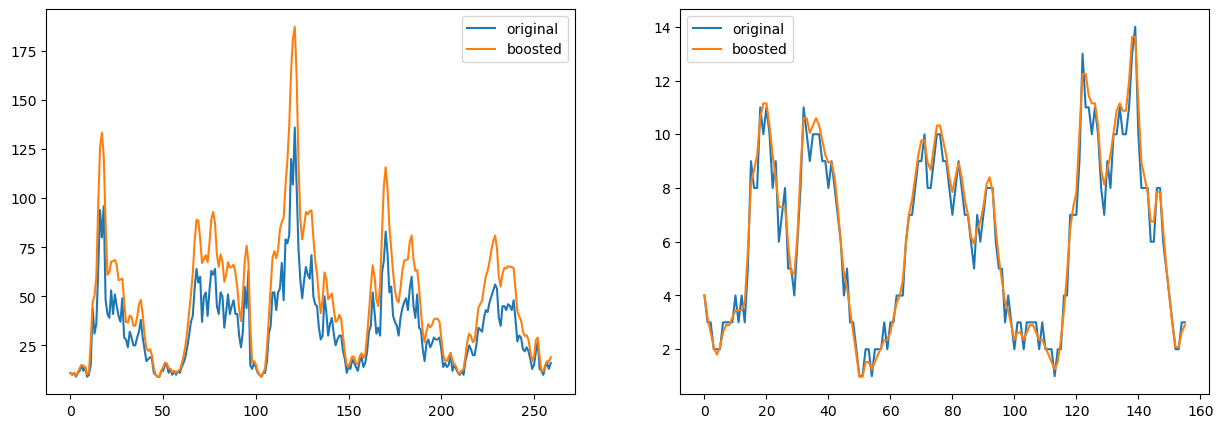

In [39]:
def peakBoost(array, scalar, mixed=None):
    #Take derivative of array
    deriv = np.gradient(array)
    #Scale derivative
    new_deriv = deriv * scalar
    #Integrate the new derivative starting from 0
    integral = cumtrapz(new_deriv, initial=0)
    length = range(len(array))
    #Add intercept to match initial range
    boosted = [x+array[0] for x in integral]
    
    #Option ways to put floors on the output
    if mixed == 'max':
        out = [max(boosted[i], array[i]) for i in length]
    elif mixed == 'pos':
        out = [max(boosted[i], 0) for i in length]
    else:
        out = boosted
    return out
sj_boost = peakBoost(sj_pred, 1.6, 'max')
iq_boost = peakBoost(iq_pred, 1.1, 'pos')
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(sj_pred, label='original')
plt.plot(sj_boost, label='boosted')
plt.legend()
plt.subplot(122)
plt.plot(iq_pred, label='original')
plt.plot(iq_boost, label='boosted')
plt.legend()
plt.show()

In [41]:
submission = pd.read_csv('../data/submission_format.csv',
                            index_col=[0, 1, 2])
submission.total_cases = np.concatenate([sj_pred, iq_pred])
submission.to_csv("submission.csv")